### Goals of this script:
- Find a reasonable box around the cyclone centre for all timesteps (first static, then dynamic and then maybe variable).
- Integrate all below-cloud-porcesses that happen in that box (individual and sum of all)
- Create plots (c.f. Joos, Wernli 12 fig.5) 

In [13]:
## Import modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import xarray as xr 
import pytz
import glob


import sys
sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
import data_preprocessing_helpers 

In [11]:
## Import data
# file_path = '/net/thermo/atmosdyn2/atroman/PACaccu/cdf'
file_path = '/net/helium/atmosdyn/freimax/data_msc/IFS-17/cdf'

# Load date of maximum intensity 
ds_p = xr.open_dataset(f'{file_path}/P20170410_17')
ds_p = ds_p.squeeze()

In [5]:
## Choose timeframe of days that will be considered
# ds_p_d2 = ds_p.sel(time=slice('20170410-00', '20170410-11'))
# ds_p_d3 = ds_p.sel(time=slice('20170410-12', '20170411-12'))
# ds_p_d = ds_p.sel(time=slice('20170410-00', '20170411-12'))



lonlat_d = [150,180, 40,60] #lonmin, lonmax, latmin, latmax



# ds_p_d_box = ds_p_d2.sel(lon=slice(lonlat_d[0], lonlat_d[1]), lat=slice(lonlat_d[2], lonlat_d[3]))
# slp_lonmin_d, slp_latmin_d = get_SLPmin_coords(ds_p_d_box)
# assert len(ds_p_d1.time.values) + len(ds_p_d2.time.values) + len(ds_p_d3.time.values) == len(ds_p.time.values)

# lonlat_d2 = [150,165, 40,55] #lonmin, lonmax, latmin, latmax
# lonlat_d3 = [160,180, 40,60] #lonmin, lonmax, latmin, latmax

# ds_p_d2_box = ds_p_d2.sel(lon=slice(lonlat_d2[0], lonlat_d2[1]), lat=slice(lonlat_d2[2], lonlat_d2[3]))
# ds_p_d3_box = ds_p_d3.sel(lon=slice(lonlat_d3[0], lonlat_d3[1]), lat=slice(lonlat_d3[2], lonlat_d3[3]))

# ds_p_bigbox = ds_p.sel(lon=slice(lonlat_d2[0], lonlat_d3[1]), lat=slice(lonlat_d2[2], lonlat_d3[3]))

In [16]:
ds_p_lonlatbox = data_preprocessing_helpers.get_lonlatbox(ds_p, lon_range=(135,-165), lat_range=(20,70))


In [45]:
ds_p_lonlatbox.SLP.time.values

numpy.datetime64('2017-04-10T17:00:00.000000000')

In [46]:
## Get min SLP for every hour
def get_SLPmin_coords(ds_SLP_field):
    slp_min = []
    slp_min_lon = []
    slp_min_lat = []
    time_step = []

    if ds_SLP_field.time.shape == ():
            min_spl_value = ds_SLP_field.SLP
            min_coords = np.unravel_index(min_spl_value.argmin(), min_spl_value.shape)
            slp_min_lon.append(float(min_spl_value.lon[min_coords[1]].values))
            slp_min_lat.append(float(min_spl_value.lat[min_coords[0]].values))

            slp_min.append(float(min_spl_value.values.min()))
            time_step.append(ds_SLP_field.SLP.time.values)
        
    else:
        for time in ds_SLP_field.time.values:
            min_spl_value = ds_SLP_field.sel(time=time).SLP
            min_coords = np.unravel_index(min_spl_value.argmin(), min_spl_value.shape)
            slp_min_lon.append(float(min_spl_value.lon[min_coords[1]].values))
            slp_min_lat.append(float(min_spl_value.lat[min_coords[0]].values))

            slp_min.append(float(min_spl_value.values.min()))
            time_step.append(time)
        
    return slp_min_lon, slp_min_lat, slp_min, time_step

slp_lonmin, slp_latmin, slp_min, time_step = get_SLPmin_coords(ds_p_lonlatbox)


# slp_lonmin_d2, slp_latmin_d2, slp_min_d2, time_step_d2 = get_SLPmin_coords(ds_p_d2_box)
# slp_lonmin_d3, slp_latmin_d3, slp_min_d3, time_step_d3 = get_SLPmin_coords(ds_p_d3_box)

# slp_lonmin =  slp_lonmin_d2 + slp_lonmin_d3
# slp_latmin =  slp_latmin_d2 + slp_latmin_d3
# slp_min =  slp_min_d2 + slp_min_d3
# time_step =  time_step_d2 + time_step_d3

In [47]:
slp_lonmin

[163.60000610351562]

In [48]:
assert len(slp_lonmin) == len(slp_latmin) == len(slp_min) == len(time_step)

In [49]:
slp_min

[964.96435546875]

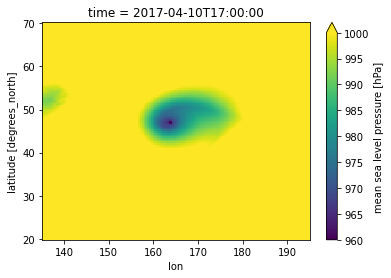

In [50]:
fig,ax = plt.subplots()
ds_p_lonlatbox.SLP.plot(ax=ax, vmin=960, vmax=1000)
ax.scatter(slp_lonmin, slp_latmin, c=time_step, s=5)


In [51]:
time_steps = [pd.Timestamp(date, tz=pytz.UTC).timestamp() for date in time_step]
time_steps1 = [pd.Timestamp(date).timestamp() for date in time_step]

/tmp/ipykernel_62294/3732315560.py:1: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  time_steps = [pd.Timestamp(date, tz=pytz.UTC).timestamp() for date in time_step]


In [52]:
# Create iid list with zeros
iid = [0.]*len(time_step)
# Combine all lists into a 2D array
data = np.column_stack((time_steps, iid, slp_lonmin, slp_latmin, slp_min))


In [53]:
print(type(time_step[0]), type(iid[0]), type(slp_lonmin[0]), type(slp_latmin[0]), type(slp_min[0]))

<class 'numpy.datetime64'> <class 'float'> <class 'float'> <class 'float'> <class 'float'>


In [54]:
data[:,:]

array([[1.49184360e+09, 0.00000000e+00, 1.63600006e+02, 4.72000008e+01,
        9.64964355e+02]])

In [55]:
# path = '/net/helium/atmosdyn/freimax/data_msc/casestudy_ra/data/TRACKED_CYCLONE.txt'
path = '/net/helium/atmosdyn/freimax/data_msc/IFS-17/trajectories/caltra/TRACKED_CYCLONE.txt'
# Save the data to a text file, with a header
np.savetxt(path, data, delimiter=" ", header='step iid lon lat inpres', comments='', fmt=['%f', '%d', '%f', '%f', '%f'])